# seqNMF Demo

This notebook demonstrates the seqNMF to both synthetic data and songbird data (provided by Emily Mackevicius).

## Setup

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.io

from cnmf import CNMF
from tests import seq_nmf_data
%matplotlib inline

## Generate synthetic data

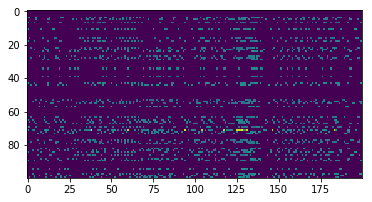

In [3]:
N = 100  # Number of neurons
T = 200  # Length of data in time
L = 10  # Max time lag
K = 2  # Number of factors
sparsity=0.75

data, Wreal, Hreal = seq_nmf_data(N, T, L, K, sparsity)

plt.imshow(data)
plt.show()

## Fit synthetic data

Let's try fitting a simple, single sequence model.

In [4]:
#Hreal /= la.norm(Hreal, axis=-1, keepdims=True)  # normalize

lam = 10**(-6)
model = CNMF(3, 10)
model.fit(data, alg='mult')

 52%|█████▏    | 52/100 [00:00<00:00, 94.13it/s]


Reconstruction Error:  0.0393040825426


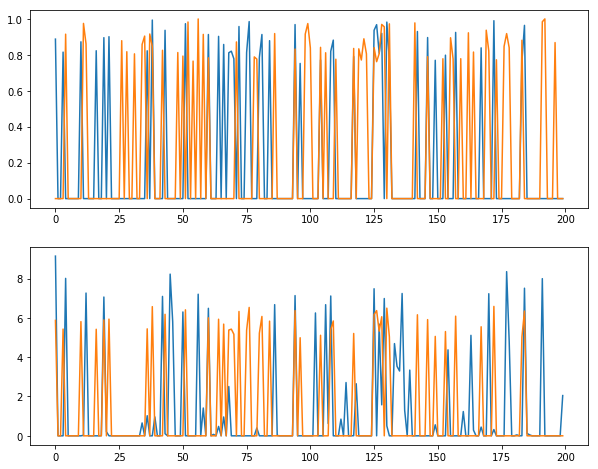

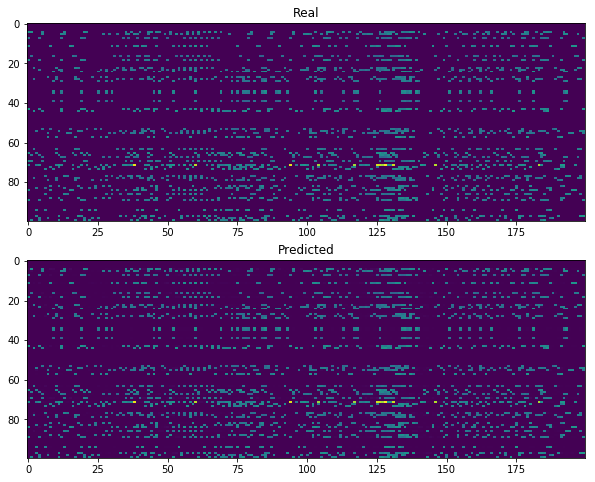

In [9]:
error = data - model.predict()
print('Reconstruction Error: ', la.norm(error) / la.norm(data))


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(range(T), Hreal[0])
plt.plot(range(T), Hreal[1])

plt.subplot(2,1,2)
plt.plot(range(T), model.H.shift(0)[0])
plt.plot(range(T), model.H.shift(0)[1])

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.imshow(data, aspect='auto')
plt.title('Real')

plt.subplot(2,1,2)
plt.imshow(model.predict(), aspect='auto')
plt.title('Predicted')

plt.show()

## Load songbird data

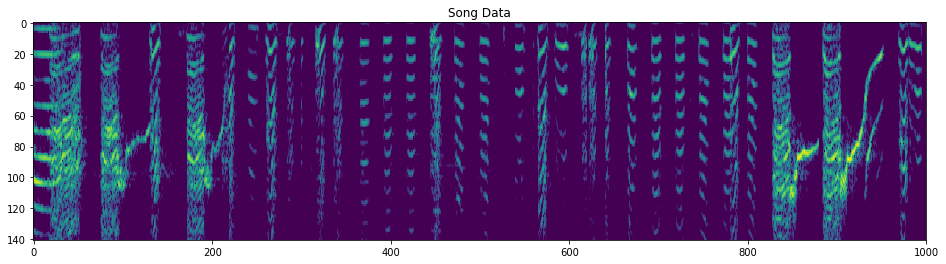

In [64]:
mat_data = scipy.io.loadmat('MackeviciusData.mat')
neural_data = mat_data['NEURAL']
song_data = mat_data['SONG']
song_split = 1000

plt.figure(figsize=(16, 4))
plt.imshow(song_data[:,:song_split], aspect='auto')
plt.title('Song Data')
plt.show()

## Fit songbird data

In [66]:
lag = 0.3  # seconds
sL = int(np.ceil(lag * mat_data['SONGfs']) / 2)
components = 8

model = CNMF(8, sL, l2_scfo=3e-4, l1_W=1e-6)
model.fit(song_data[:,:song_split], alg='mult')


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Reconstruction Error:  0.343597047855


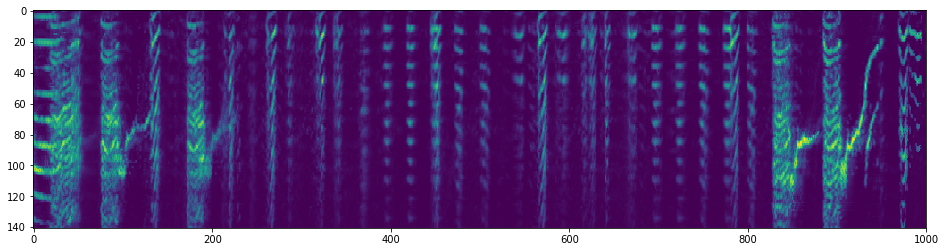

In [78]:
song_est = model.predict()
error = song_est[:,:song_split] - song_data[:,:song_split]
print("Reconstruction Error: ", la.norm(error) / la.norm(song_data[:,:song_split]))
plt.figure(figsize=(16,4))
plt.imshow(song_est, aspect='auto')
plt.show()

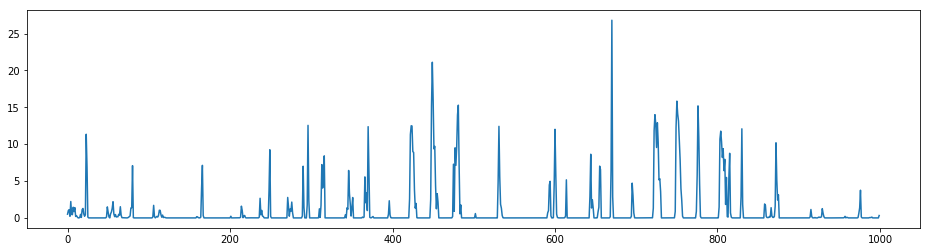

In [89]:
plt.figure(figsize=(16,4))
plt.plot(model.H.shift(0)[0])